<a href="https://colab.research.google.com/github/danbennett239/CI603/blob/main/CI603_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection: Anomaly Detection Implementation

## Introduction and Setup Instructions

### Dataset Overview


This notebook implements anomaly detection models for the **Credit Card Fraud Detection** dataset, sourced from Kaggle (Machine Learning Group - ULB, 2016). The dataset contains 284,807 credit card transactions, with 492 (0.172%) labeled as fraudulent, making it highly imbalanced. It includes 30 features: `Time`, `Amount`, and 28 anonymized PCA-transformed features (`V1`–`V28`), with a binary `Class` label (0 = normal, 1 = fraudulent). The dataset is ideal for evaluating unsupervised anomaly detection due to its imbalance and preprocessed PCA features.

### Setup Instructions


1. **Download the Dataset**:
   - Obtain the dataset from Kaggle: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).
   - Upload `creditcard.csv` to your Google Drive under the path `/content/drive/MyDrive/CI603/`.
2. **Mount Google Drive**:
   - Run the cell below to mount your Google Drive in Colab.
3. **Install Dependencies**:
   - Ensure Python libraries (`pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`) are installed (pre-installed in Colab).
4. **Run the Notebook**:
   - Execute cells sequentially to perform exploratory data analysis, feature selection, model training, and evaluation.

## Import Libraries

#### Import Required Libraries

In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import IsolationForest
from itertools import product
from scipy.stats import norm

## Mount Google Drive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

# If already mounted, a message indicates no remount is needed unless force_remount=True is used.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model Evaluation Functions

### ROC and Precision-Recall Curve Functions

#### Define ROC and PR Evaluation Function

In [41]:
# Function to compute and plot ROC and Precision-Recall curves with AUC
def evaluate_roc_pr_metrics(y_true, y_scores, model_name):
    # ROC Curve: True Positive Rate vs False Positive Rate
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Plot both curves side by side
    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.grid(True)

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{model_name}_roc_pr_curves.png")
    plt.show()

    return roc_auc, pr_auc

#### Compute ROC and PR Metrics

In [42]:
# Function to compute ROC and Precision-Recall metrics without plotting
def compute_roc_pr_metrics(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    return fpr, tpr, precision, recall, roc_auc, pr_auc

#### Plot ROC and PR Curves

In [43]:
# Function to plot ROC and Precision-Recall curves
def plot_roc_pr(fpr, tpr, precision, recall, roc_auc, pr_auc, model_name):
    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.grid(True)

    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUC = {pr_auc:.4f}', color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{model_name}_roc_pr_curves.png")
    plt.show()

## Dataset Description and Visualisation

#### Load and Inspect Dataset

In [44]:
# Load the dataset and check its shape, column names, and missing values
df = pd.read_csv('/content/drive/MyDrive/CI603/creditcard.csv')
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

missing = df.isnull().sum()
print("\nMissing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

Dataset shape: (284807, 31)

Column names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing values per column:
No missing values found.


#### Class Distribution and Imbalance

In [45]:
# Display fraud vs normal class counts and their percentage
class_counts = df['Class'].value_counts()
total = class_counts.sum()
fraud_pct = (class_counts[1] / total) * 100
normal_pct = (class_counts[0] / total) * 100

print("\nClass Distribution:")
print(f"Normal transactions: {class_counts[0]} ({normal_pct:.4f}%)")
print(f"Fraudulent transactions: {class_counts[1]} ({fraud_pct:.4f}%)")


Class Distribution:
Normal transactions: 284315 (99.8273%)
Fraudulent transactions: 492 (0.1727%)


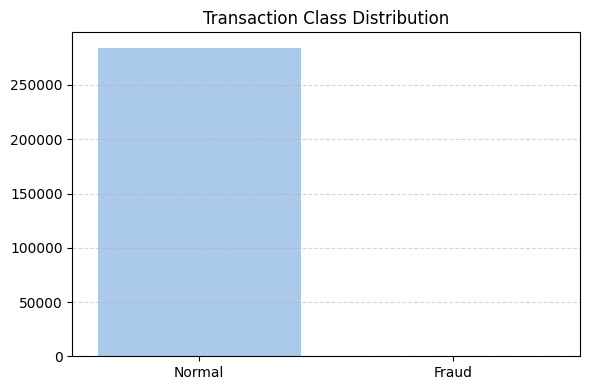

In [46]:
# Bar plot of transaction counts by class
plt.figure(figsize=(6, 4))
sns.barplot(x=['Normal', 'Fraud'], y=class_counts.values, hue=['Normal', 'Fraud'], palette='pastel', legend=False)
plt.title('Transaction Class Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

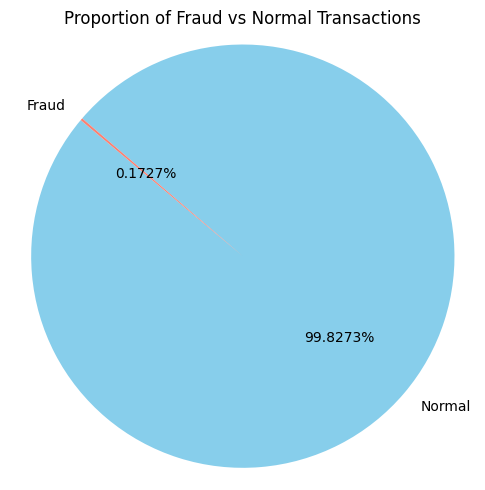

In [47]:
# Pie chart showing class proportions
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=['Normal', 'Fraud'], autopct='%1.4f%%', colors=['skyblue', 'salmon'], startangle=140)
plt.title('Proportion of Fraud vs Normal Transactions')
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Summary Statistics for Time, Amount, and PCA Features

In [48]:
# Summary statistics for time and amount
print("\nSummary Statistics for Time and Amount:")
print(df[['Time', 'Amount']].describe())

# Summary statistics for V1–V28 PCA features
print("\nPCA Features Summary (V1–V28):")
print(df[[f'V{i}' for i in range(1, 29)]].describe())


Summary Statistics for Time and Amount:
                Time         Amount
count  284807.000000  284807.000000
mean    94813.859575      88.349619
std     47488.145955     250.120109
min         0.000000       0.000000
25%     54201.500000       5.600000
50%     84692.000000      22.000000
75%    139320.500000      77.165000
max    172792.000000   25691.160000

PCA Features Summary (V1–V28):
                 V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15  9.604066e-16   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7

#### Correlation Analysis

In [49]:
# Correlation of Time and scaled Amount with the Class label
df['Amount_scaled'] = StandardScaler().fit_transform(df[['Amount']])
corr = df[['Amount_scaled', 'Time', 'Class']].corr()['Class']
print("\nCorrelation with Class:")
print(corr)


Correlation with Class:
Amount_scaled    0.005632
Time            -0.012323
Class            1.000000
Name: Class, dtype: float64


#### Distribution Visualisations

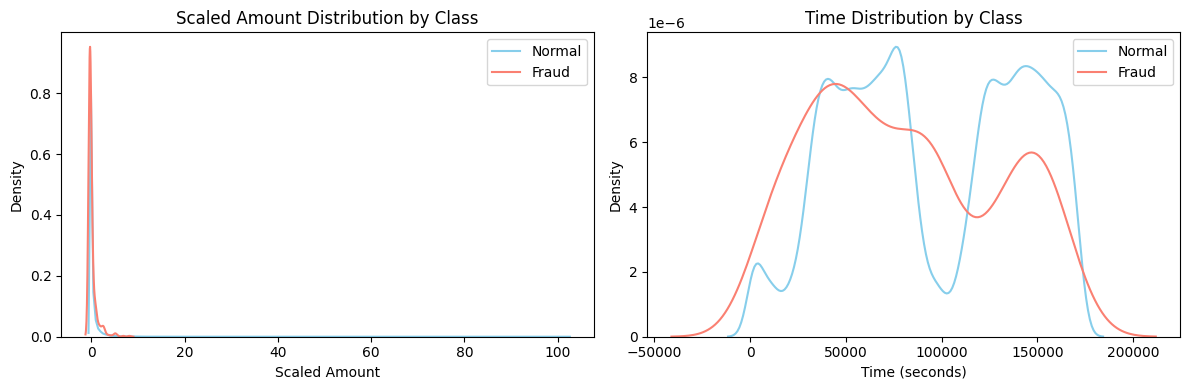

In [50]:
# KDE plots showing distributions of Time and Amount_scaled by class
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df[df['Class'] == 0], x='Amount_scaled', label='Normal', color='skyblue')
sns.kdeplot(data=df[df['Class'] == 1], x='Amount_scaled', label='Fraud', color='salmon')
plt.title('Scaled Amount Distribution by Class')
plt.xlabel('Scaled Amount')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=df[df['Class'] == 0], x='Time', label='Normal', color='skyblue')
sns.kdeplot(data=df[df['Class'] == 1], x='Time', label='Fraud', color='salmon')
plt.title('Time Distribution by Class')
plt.xlabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.savefig("intro_amount_time_dist.png")
plt.show()


#### Boxplot of Transaction Amounts by Class

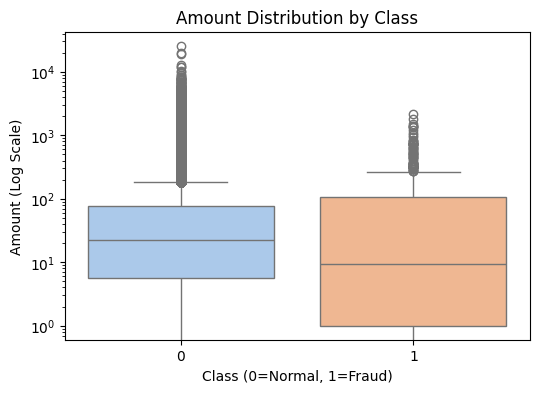

In [51]:
# Boxplot comparing transaction amounts across classes (log scale)
plt.figure(figsize=(6, 4))
sns.boxplot(x='Class', y='Amount', data=df, palette='pastel', hue='Class', legend=False)
plt.title('Amount Distribution by Class')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Amount (Log Scale)')
plt.yscale('log')
plt.savefig("intro_amount_boxplot.png")
plt.show()

#### Temporal Distribution of Fraudulent Transactions

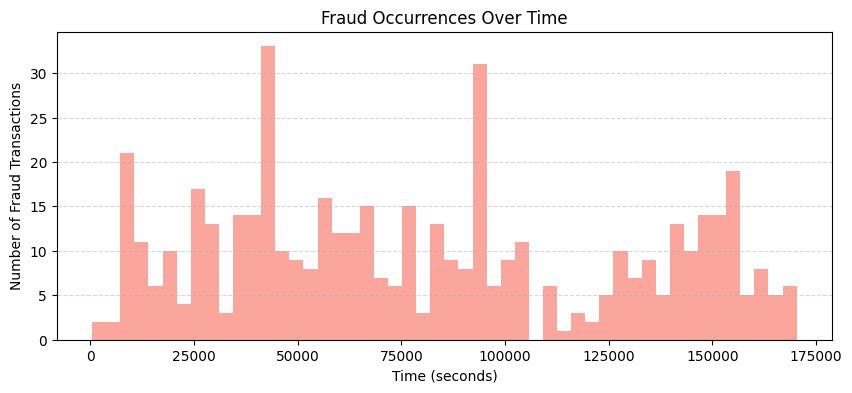

In [52]:
# Histogram showing when fraud occurs over the dataset's time range
plt.figure(figsize=(10, 4))
fraud_times = df[df['Class'] == 1]['Time']
plt.hist(fraud_times, bins=50, color='salmon', alpha=0.7)
plt.title('Fraud Occurrences Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Fraud Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("intro_fraud_time_series.png")
plt.show()

#### PCA Feature Scale Verification

In [53]:
# Check that PCA components are roughly standardised (mean≈0, std≈1)
pca_stats = pd.DataFrame({
    'Mean': df[[f'V{i}' for i in range(1, 29)]].mean(),
    'Std': df[[f'V{i}' for i in range(1, 29)]].std()
})
print("\nPCA Features Scale Verification (Means and Stds):")
print(pca_stats.describe())


PCA Features Scale Verification (Means and Stds):
               Mean        Std
count  2.800000e+01  28.000000
mean   7.627408e-16   0.976391
std    1.541343e-15   0.386740
min   -2.406331e-15   0.330083
25%   -1.812691e-16   0.732318
50%    7.298102e-16   0.936956
75%    1.450115e-15   1.205038
max    4.887456e-15   1.958696


## Feature Selection and Dimensionality Reduction

#### Feature Scaling

In [54]:
# Scales Amount using StandardScaler to ensure consistency with PCA features.
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
print("Correlation with Class:")
print(df[['Amount_scaled', 'Time', 'Class']].corr()['Class'])

Correlation with Class:
Amount_scaled    0.005632
Time            -0.012323
Class            1.000000
Name: Class, dtype: float64


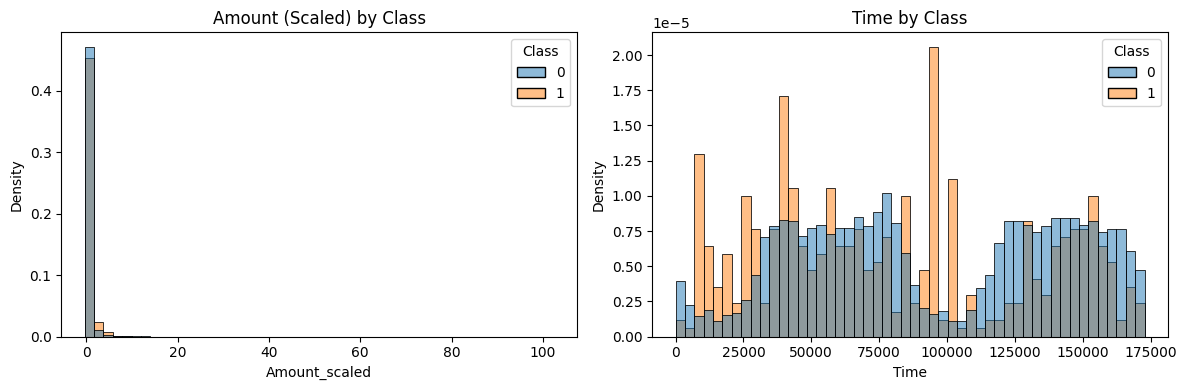

In [55]:
# Visualize distributions of scaled Amount and Time by class
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Amount_scaled', hue='Class', bins=50, stat='density', common_norm=False)
plt.title('Amount (Scaled) by Class')
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Time', hue='Class', bins=50, stat='density', common_norm=False)
plt.title('Time by Class')
plt.tight_layout()
plt.show()

#### Random Forest Feature Importance

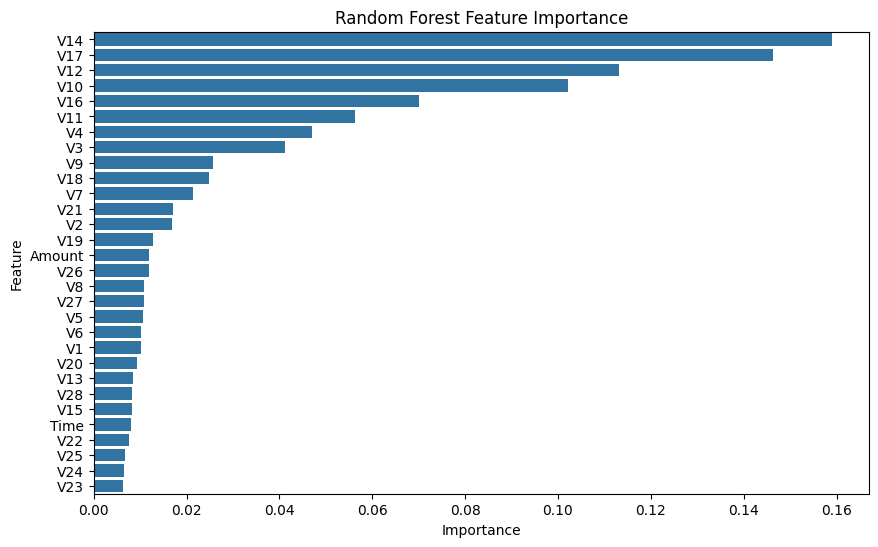

In [56]:
# Prepare features and target for Random Forest
X = df.drop(['Class', 'Amount_scaled'], axis=1)
y = df['Class']

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.show()

Threshold 0.01: 21 features - ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3', 'V9', 'V18', 'V7', 'V21', 'V2', 'V19', 'Amount', 'V26', 'V8', 'V27', 'V5', 'V6', 'V1']
Threshold 0.02: 11 features - ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3', 'V9', 'V18', 'V7']
Threshold 0.03: 8 features - ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3']


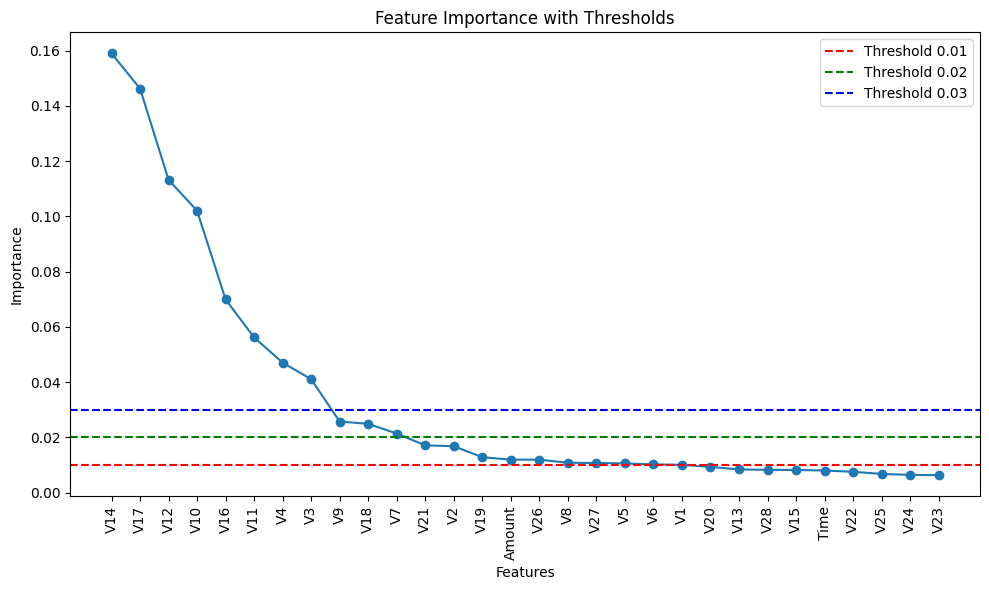

In [57]:
# Test different importance thresholds
thresholds = [0.01, 0.02, 0.03]
for thresh in thresholds:
    selected_features = feature_importance[feature_importance['Importance'] > thresh]['Feature'].tolist()
    print(f"Threshold {thresh}: {len(selected_features)} features - {selected_features}")

# Visualize importance distribution to assess threshold
plt.figure(figsize=(10, 6))
plt.plot(range(len(feature_importance)), feature_importance['Importance'], marker='o')
plt.axhline(y=0.01, color='r', linestyle='--', label='Threshold 0.01')
plt.axhline(y=0.02, color='g', linestyle='--', label='Threshold 0.02')
plt.axhline(y=0.03, color='b', linestyle='--', label='Threshold 0.03')
plt.xticks(range(len(feature_importance)), feature_importance['Feature'], rotation=90)
plt.title('Feature Importance with Thresholds')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# Select final features and save reduced dataset
final_threshold = 0.02
selected_features = feature_importance[feature_importance['Importance'] > final_threshold]['Feature'].tolist()
reduced_df = df[selected_features + ['Class']].copy()
print("Reduced dataset shape:", reduced_df.shape)
print("Selected features:", selected_features)

# Save reduced dataset
reduced_df.to_csv("reduced_creditcard.csv", index=False)

Reduced dataset shape: (284807, 12)
Selected features: ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V3', 'V9', 'V18', 'V7']


In [59]:
# Verify feature scales
print("Feature means:\n", reduced_df.drop('Class', axis=1).mean())
print("Feature stds:\n", reduced_df.drop('Class', axis=1).std())

Feature means:
 V14    1.207294e-15
V17   -3.772171e-16
V12   -1.247012e-15
V10    2.239053e-15
V16    1.437716e-15
V11    1.673327e-15
V4     2.074095e-15
V3    -1.379537e-15
V9    -2.406331e-15
V18    9.564149e-16
V7    -5.556467e-16
dtype: float64
Feature stds:
 V14    0.958596
V17    0.849337
V12    0.999201
V10    1.088850
V16    0.876253
V11    1.020713
V4     1.415869
V3     1.516255
V9     1.098632
V18    0.838176
V7     1.237094
dtype: float64


## Data Splitting

#### Split Dataset for Training and Evaluation

In [60]:
# Initialize results and curve_metrics
results = [] # List to store evaluation metrics
curve_metrics = []  # List to store ROC and PR curve data (fpr, tpr, prec, rec)

# Load reduced dataset
reduced_df = pd.read_csv("reduced_creditcard.csv")

# Split data (60% normal, 20% normal + 50% fraud for CV, 20% normal + 50% fraud for test)
normal = reduced_df[reduced_df['Class'] == 0].copy()
fraud = reduced_df[reduced_df['Class'] == 1].copy()
train_fraud = normal.sample(frac=0.6, random_state=42).copy()
remaining_normal = normal.drop(train_fraud.index)
train_cv = pd.concat([remaining_normal.sample(frac=0.5, random_state=42), fraud.sample(frac=0.5, random_state=42)]).copy()
train_test = pd.concat([
    remaining_normal.drop(train_cv.index.intersection(remaining_normal.index)),
    fraud.drop(train_cv.index.intersection(fraud.index))
]).copy()

# Separate features and labels
train_fraud_X = train_fraud.drop('Class', axis=1).copy()
train_cv_X = train_cv.drop('Class', axis=1).copy()
train_cv_y = train_cv['Class'].copy()
train_test_X = train_test.drop('Class', axis=1).copy()
train_test_y = train_test['Class'].copy()

## Univariate Gaussian Model

### Model Implementation and Threshold Tuning

#### Define and Train Univariate Gaussian

In [61]:
# Compute mean and standard deviation for Univariate Gaussian
mu = train_fraud_X.mean(axis=0).values
sigma = train_fraud_X.std(axis=0).values

# Define Univariate Gaussian function
def univariate_gaussian(X, mu, sigma):
    p = np.ones(X.shape[0])
    for i in range(len(mu)):
        p *= norm.pdf(X[:, i], mu[i], sigma[i])
    return p

# Compute probabilities
p_cv = univariate_gaussian(train_cv_X.values, mu, sigma)
p_test = univariate_gaussian(train_test_X.values, mu, sigma)

#### Threshold Tuning and Evaluation

Univariate Gaussian Cross-Validation (Threshold Tuning)
Best epsilon:     5.18e-55
F1 Score:         0.6486
Precision:        0.7273
Recall:           0.5854

Univariate Gaussian Test Set Results
F1 Score:         0.6196
Precision:        0.7047
Recall:           0.5528
ROC AUC:          0.9594
PR AUC:           0.6285


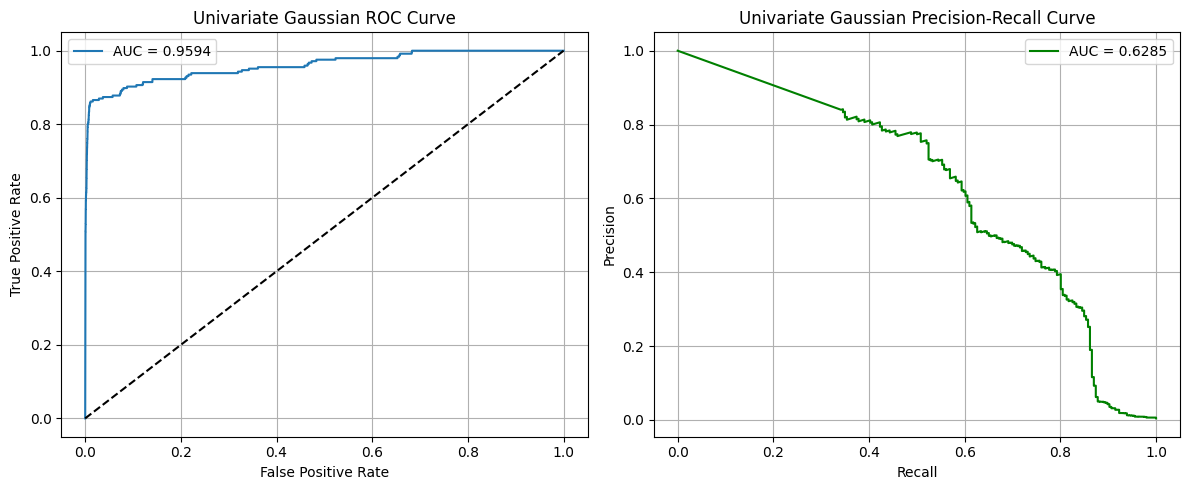

In [62]:
# Tune thresholds
epsilons = np.logspace(-100, -20, 50)
best_f1 = 0
best_epsilon = None
best_precision = 0
best_recall = 0

for epsilon in epsilons:
    preds = (p_cv < epsilon).astype(int)
    f1 = f1_score(train_cv_y, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision_score(train_cv_y, preds)
        best_recall = recall_score(train_cv_y, preds)


# Evaluate on test set
test_preds = (p_test < best_epsilon).astype(int)
test_f1 = f1_score(train_test_y, test_preds)
test_precision = precision_score(train_test_y, test_preds)
test_recall = recall_score(train_test_y, test_preds)

p_test_scores = -np.log(p_test + 1e-100)
fpr, tpr, prec_curve, rec_curve, roc_auc, pr_auc = compute_roc_pr_metrics(train_test_y, p_test_scores)

# Print results
print("Univariate Gaussian Cross-Validation (Threshold Tuning)")
print(f"Best epsilon:     {best_epsilon:.2e}")
print(f"F1 Score:         {best_f1:.4f}")
print(f"Precision:        {best_precision:.4f}")
print(f"Recall:           {best_recall:.4f}")

print("\nUnivariate Gaussian Test Set Results")
print(f"F1 Score:         {test_f1:.4f}")
print(f"Precision:        {test_precision:.4f}")
print(f"Recall:           {test_recall:.4f}")
print(f"ROC AUC:          {roc_auc:.4f}")
print(f"PR AUC:           {pr_auc:.4f}")

# Plot ROC and PR curves
plot_roc_pr(fpr, tpr, prec_curve, rec_curve, roc_auc, pr_auc, "Univariate Gaussian")

# Store results
results.append({
    'Model': 'Univariate Gaussian',
    'F1': test_f1,
    'Precision': test_precision,
    'Recall': test_recall,
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
})

# Store curve metrics
curve_metrics.append({
    'Model': 'Univariate Gaussian',
    'fpr': fpr.tolist(),  # Convert to list for JSON compatibility
    'tpr': tpr.tolist(),
    'prec_curve': prec_curve.tolist(),
    'rec_curve': rec_curve.tolist(),
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
})

## Robust Univariate Gaussian Model (Descoped)

Descoped due to overfitting concerns and poor performance, further detials in Section 4.1 of the report. Results not stored for final evaluation.

### Model Implementation and Threshold Tuning

#### Define and Train Robust Univariate Gaussian

In [63]:
# Compute median and IQR-based standard deviation for robust variant
mu = train_fraud_X.median().values
iqr = train_fraud_X.quantile(0.75) - train_fraud_X.quantile(0.25)
sigma = (iqr / 1.349).values  # IQR to std conversion (approx for normal dist)

# Define log-based Univariate Gaussian function
def log_univariate_gaussian(X, mu, sigma):
    log_p = np.zeros(X.shape[0])
    for i in range(len(mu)):
        log_p += norm.logpdf(X[:, i], mu[i], sigma[i])
    return log_p

# Compute log probabilities
p_cv = log_univariate_gaussian(train_cv_X.values, mu, sigma)
p_test = log_univariate_gaussian(train_test_X.values, mu, sigma)

#### Threshold Tuning and Evaluation

Robust Univariate Gaussian Cross-Validation (Threshold Tuning)
Best epsilon (log prob): -193.3822
F1 Score:         0.6264
Precision:        0.6965
Recall:           0.5691

Robust Univariate Gaussian Test Set Results
F1 Score:         0.5864
Precision:        0.6649
Recall:           0.5244
ROC AUC:          0.9612
PR AUC:           0.5981


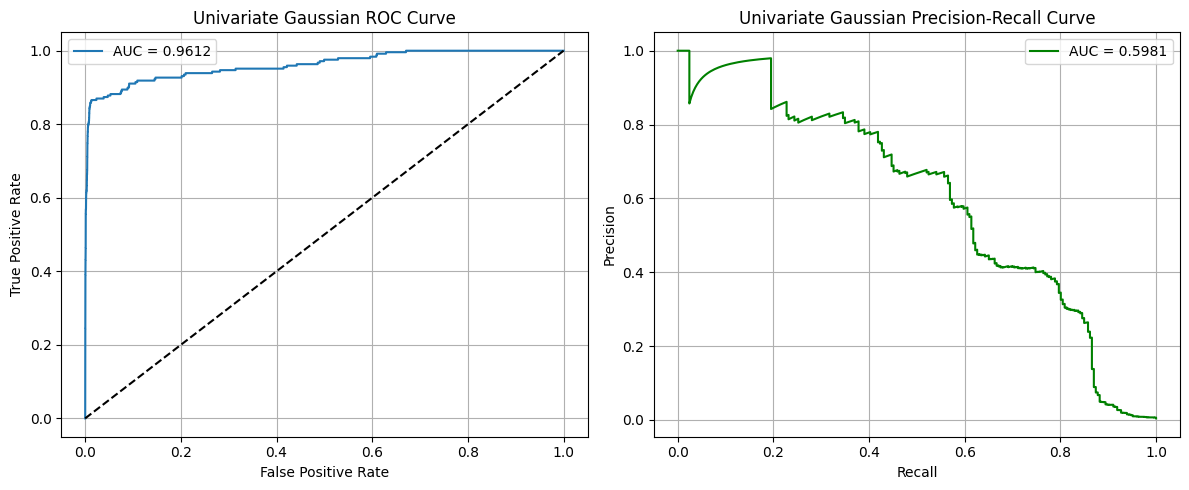

In [64]:
# Tune thresholds
epsilons = np.linspace(np.min(p_cv), np.max(p_cv), 100)
best_f1 = 0
best_epsilon = None
best_precision = 0
best_recall = 0

for epsilon in epsilons:
    preds = (p_cv < epsilon).astype(int)
    f1 = f1_score(train_cv_y, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision_score(train_cv_y, preds)
        best_recall = recall_score(train_cv_y, preds)



# Evaluate on test set
test_preds = (p_test < best_epsilon).astype(int)
test_f1 = f1_score(train_test_y, test_preds)
test_precision = precision_score(train_test_y, test_preds)
test_recall = recall_score(train_test_y, test_preds)

fpr, tpr, prec_curve, rec_curve, roc_auc, pr_auc = compute_roc_pr_metrics(train_test_y, -p_test)

# Print results
print("Robust Univariate Gaussian Cross-Validation (Threshold Tuning)")
print(f"Best epsilon (log prob): {best_epsilon:.4f}")
print(f"F1 Score:         {best_f1:.4f}")
print(f"Precision:        {best_precision:.4f}")
print(f"Recall:           {best_recall:.4f}")


print("\nRobust Univariate Gaussian Test Set Results")
print(f"F1 Score:         {test_f1:.4f}")
print(f"Precision:        {test_precision:.4f}")
print(f"Recall:           {test_recall:.4f}")
print(f"ROC AUC:          {roc_auc:.4f}")
print(f"PR AUC:           {pr_auc:.4f}")

# Plot ROC and PR curves
plot_roc_pr(fpr, tpr, prec_curve, rec_curve, roc_auc, pr_auc, "Univariate Gaussian")

# Results not stored as they are not required in the final evaluation due to being descoped.

# results.append({
#     'Model': 'Robust Univariate Gaussian',
#     'F1': test_f1,
#     'Precision': test_precision,
#     'Recall': test_recall,
#     'ROC AUC': roc_auc,
#     'PR AUC': pr_auc
# })

## Multivariate Gaussian Model

### Model Implementation and Threshold Tuning

#### Define and Train Multivariate Gaussian

In [65]:
# Define Multivariate Gaussian function
def multivariate_gaussian(X, mu, sigma):
    k = len(mu)
    sigma_inv = np.linalg.inv(sigma)
    det_sigma = np.linalg.det(sigma)
    const = 1 / ((2 * np.pi) ** (k / 2) * det_sigma ** 0.5)
    diff = X - mu
    exp_term = np.sum(np.dot(diff, sigma_inv) * diff, axis=1)
    return const * np.exp(-0.5 * exp_term)

# Compute mean and covariance from training data
mu = train_fraud_X.mean().values
sigma = np.cov(train_fraud_X.T)
p_cv = multivariate_gaussian(train_cv_X.values, mu, sigma)
p_test = multivariate_gaussian(train_test_X.values, mu, sigma)

#### Threshold Tuning and Evaluation

Cross-Validation Results (Threshold Tuning)
Best epsilon:     1.46e-92
F1 Score:         0.8460
Precision:        0.9070
Recall:           0.7927

Test Set Results (Using Best Epsilon)
F1 Score:         0.8000
Precision:        0.8708
Recall:           0.7398
ROC AUC:          0.9591
PR AUC:           0.7662


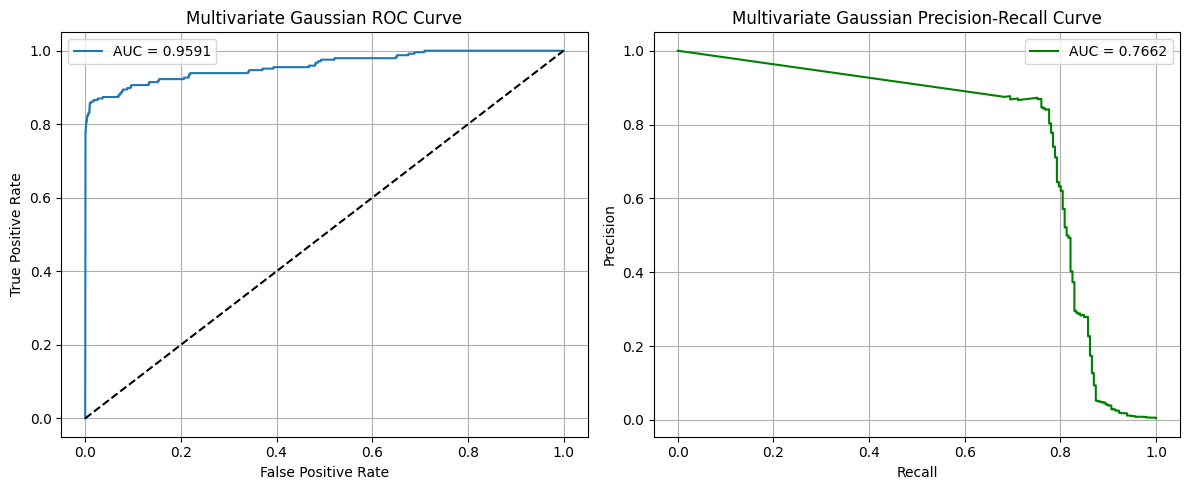

In [66]:
# Test epsilon range for threshold tuning
epsilons = np.logspace(-100, -20, num=50)
best_f1 = 0
best_epsilon = 0
for epsilon in epsilons:
    predictions = (p_cv < epsilon).astype(int)
    f1 = f1_score(train_cv_y, predictions)
    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision_score(train_cv_y, predictions)
        best_recall = recall_score(train_cv_y, predictions)



# Evaluate on test set
p_test_scores = -np.log(p_test + 1e-100)
fpr, tpr, prec, rec, roc_auc, pr_auc = compute_roc_pr_metrics(train_test_y, p_test_scores)


test_predictions = (p_test < best_epsilon).astype(int)
test_f1 = f1_score(train_test_y, test_predictions)
test_precision = precision_score(train_test_y, test_predictions)
test_recall = recall_score(train_test_y, test_predictions)

# Print results
print("Cross-Validation Results (Threshold Tuning)")
print(f"Best epsilon:     {best_epsilon:.2e}")
print(f"F1 Score:         {best_f1:.4f}")
print(f"Precision:        {best_precision:.4f}")
print(f"Recall:           {best_recall:.4f}")
print()

print("Test Set Results (Using Best Epsilon)")
print(f"F1 Score:         {test_f1:.4f}")
print(f"Precision:        {test_precision:.4f}")
print(f"Recall:           {test_recall:.4f}")
print(f"ROC AUC:          {roc_auc:.4f}")
print(f"PR AUC:           {pr_auc:.4f}")

# Plot ROC and PR curves
plot_roc_pr(fpr, tpr, prec, rec, roc_auc, pr_auc, "Multivariate Gaussian")

# Store results for evaluation
results.append({
    'Model': 'Multivariate Gaussian',
    'F1': test_f1,
    'Precision': test_precision,
    'Recall': test_recall,
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
})

# Store curve metrics
curve_metrics.append({
    'Model': 'Multivariate Gaussian',
    'fpr': fpr.tolist(),  # Convert to list for JSON compatibility
    'tpr': tpr.tolist(),
    'prec_curve': prec_curve.tolist(),
    'rec_curve': rec_curve.tolist(),
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
})

## Isolation Forest Model

### Initial Implementation

#### Train and Evaluate Initial Isolation Forest

In [67]:
# Train Isolation Forest with default contamination
iso_forest = IsolationForest(contamination=0.0017, random_state=42, n_jobs=-1)
iso_forest.fit(train_fraud_X)
cv_predictions = iso_forest.predict(train_cv_X)
cv_predictions = [1 if x == -1 else 0 for x in cv_predictions]  # -1 = anomaly, 1 = fraud
test_predictions = iso_forest.predict(train_test_X)
test_predictions = [1 if x == -1 else 0 for x in test_predictions]

# Evaluate
print("Isolation Forest Cross-validation:")
print(f"F1: {f1_score(train_cv_y, cv_predictions)}")
print(f"Precision: {precision_score(train_cv_y, cv_predictions)}")
print(f"Recall: {recall_score(train_cv_y, cv_predictions)}")
print("Isolation Forest Test:")
print(f"F1: {f1_score(train_test_y, test_predictions)}")
print(f"Precision: {precision_score(train_test_y, test_predictions)}")
print(f"Recall: {recall_score(train_test_y, test_predictions)}")

Isolation Forest Cross-validation:
F1: 0.6690909090909091
Precision: 0.6052631578947368
Recall: 0.7479674796747967
Isolation Forest Test:
F1: 0.6507352941176471
Precision: 0.5939597315436241
Recall: 0.7195121951219512


### Isolation Forest with Threshold Tuning

#### Train and Tune Isolation Forest

Isolation Forest Cross-Validation (Threshold Tuning)
Threshold = bottom 0.1% → F1: 0.3487, Precision: 0.9138, Recall: 0.2154
Threshold = bottom 0.5% → F1: 0.6729, Precision: 0.6259, Recall: 0.7276
Threshold = bottom 1% → F1: 0.4988, Precision: 0.3566, Recall: 0.8293
Threshold = bottom 2% → F1: 0.3067, Precision: 0.1864, Recall: 0.8659
Threshold = bottom 5% → F1: 0.1418, Precision: 0.0770, Recall: 0.8943

Best CV Threshold Selected
Best threshold:  bottom 0.5%
F1 Score:         0.6729
Precision:        0.6259
Recall:           0.7276

Isolation Forest Test Set Results
F1 Score:         0.6564
Precision:        0.6218
Recall:           0.6951
ROC AUC:          0.9577
PR AUC:           0.6699


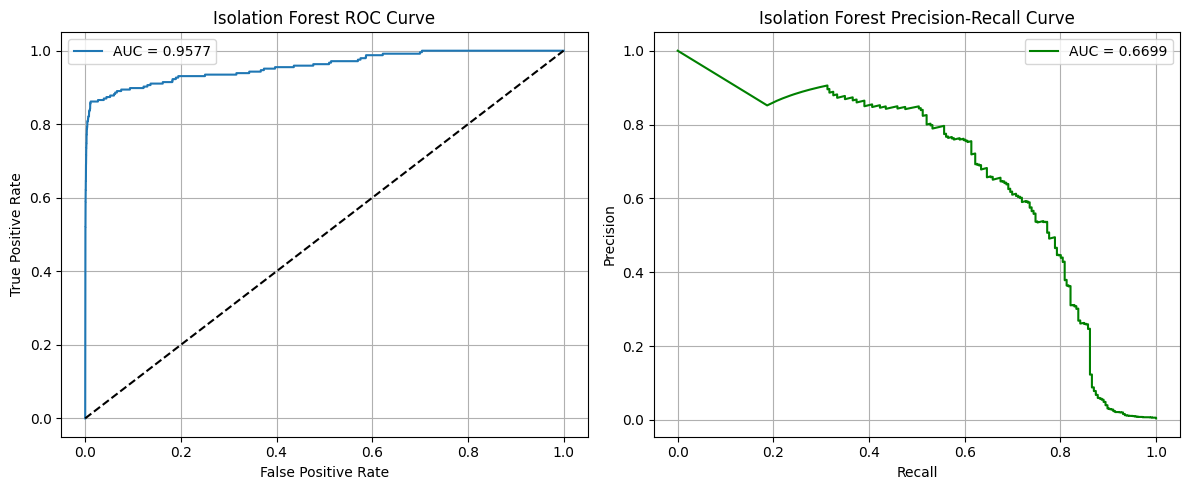

In [68]:
# Train Isolation Forest and tune thresholds
iso_forest = IsolationForest(n_estimators=100, random_state=42, n_jobs=-1)
iso_forest.fit(train_fraud_X)

cv_scores = iso_forest.score_samples(train_cv_X)  # Higher = more normal
test_scores = iso_forest.score_samples(train_test_X)

print("Isolation Forest Cross-Validation (Threshold Tuning)")
best_f1 = 0
best_threshold = None
best_percentile = None
best_precision = 0
best_recall = 0

for p in [0.1, 0.5, 1, 2, 5]:
    threshold = np.percentile(cv_scores, p)
    cv_preds = (cv_scores < threshold).astype(int)

    f1 = f1_score(train_cv_y, cv_preds)
    precision = precision_score(train_cv_y, cv_preds)
    recall = recall_score(train_cv_y, cv_preds)

    print(f"Threshold = bottom {p}% → F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_percentile = p
        best_precision = precision
        best_recall = recall

print("\nBest CV Threshold Selected")
print(f"Best threshold:  bottom {best_percentile}%")
print(f"F1 Score:         {best_f1:.4f}")
print(f"Precision:        {best_precision:.4f}")
print(f"Recall:           {best_recall:.4f}")

test_preds = (test_scores < best_threshold).astype(int)
test_f1 = f1_score(train_test_y, test_preds)
test_precision = precision_score(train_test_y, test_preds)
test_recall = recall_score(train_test_y, test_preds)

fpr, tpr, prec_curve, rec_curve, roc_auc, pr_auc = compute_roc_pr_metrics(train_test_y, -test_scores)

print("\nIsolation Forest Test Set Results")
print(f"F1 Score:         {test_f1:.4f}")
print(f"Precision:        {test_precision:.4f}")
print(f"Recall:           {test_recall:.4f}")
print(f"ROC AUC:          {roc_auc:.4f}")
print(f"PR AUC:           {pr_auc:.4f}")

plot_roc_pr(fpr, tpr, prec_curve, rec_curve, roc_auc, pr_auc, "Isolation Forest")

results.append({
    'Model': 'Isolation Forest (Threshold Tuning)',
    'F1': test_f1,
    'Precision': test_precision,
    'Recall': test_recall,
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
})

# Store curve metrics
curve_metrics.append({
    'Model': 'Isolation Forest (Threshold Tuning)',
    'fpr': fpr.tolist(),  # Convert to list for JSON compatibility
    'tpr': tpr.tolist(),
    'prec_curve': prec_curve.tolist(),
    'rec_curve': rec_curve.tolist(),
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
})

### Isolation Forest with Hyperparameter Tuning (Descoped)

Descoped due to overfitting concerns and poor performance, further detials in Section 4.3 of the report. Results not stored for final evaluation.

#### Perform Grid Search for Hyperparameters

In [69]:
# Grid for hyperparameter tuning
n_estimators_list = [100, 200]
max_samples_list = [256, 512, len(train_fraud_X)]
max_features_list = [1.0, 0.8]
random_states = [42, 123]
percentiles = [0.1, 0.5, 1, 2, 5]

# Tracking best result
best_config = None
best_f1 = 0
iteration_results = []

print("Isolation Forest Full Tuning Grid Search:\n")

# Step through all combinations
for n_est, m_samp, m_feat, r_seed in product(n_estimators_list, max_samples_list, max_features_list, random_states):
    # Train Isolation Forest
    iso = IsolationForest(
        n_estimators=n_est,
        max_samples=m_samp,
        max_features=m_feat,
        random_state=r_seed,
        n_jobs=-1
    )
    iso.fit(train_fraud_X)

    # Score samples
    cv_scores = iso.score_samples(train_cv_X)
    test_scores = iso.score_samples(train_test_X)

    for p in percentiles:
        threshold = np.percentile(cv_scores, p)
        cv_preds = (cv_scores < threshold).astype(int)

        f1 = f1_score(train_cv_y, cv_preds)
        precision = precision_score(train_cv_y, cv_preds)
        recall = recall_score(train_cv_y, cv_preds)

        iteration_results.append({
            'n_estimators': n_est,
            'max_samples': m_samp,
            'max_features': m_feat,
            'random_state': r_seed,
            'percentile': p,
            'cv_f1': f1,
            'cv_precision': precision,
            'cv_recall': recall
        })

        if f1 > best_f1:
            best_f1 = f1
            best_config = {
                'n_estimators': n_est,
                'max_samples': m_samp,
                'max_features': m_feat,
                'random_state': r_seed,
                'percentile': p,
                'threshold': threshold
            }

        print(f"n={n_est}, ms={m_samp}, mf={m_feat}, seed={r_seed}, p={p}% → F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Final test evaluation with best config
print("\nBest Configuration:")
print(best_config)

# Re-train with best config and evaluate on test set
iso_best = IsolationForest(
    n_estimators=best_config['n_estimators'],
    max_samples=best_config['max_samples'],
    max_features=best_config['max_features'],
    random_state=best_config['random_state'],
    n_jobs=-1
)
iso_best.fit(train_fraud_X)
test_scores = iso_best.score_samples(train_test_X)
test_preds = (test_scores < best_config['threshold']).astype(int)

f1 = f1_score(train_test_y, test_preds)
precision = precision_score(train_test_y, test_preds)
recall = recall_score(train_test_y, test_preds)

print("\nIsolation Forest Test Set Results:")
print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Isolation Forest Full Tuning Grid Search:

n=100, ms=256, mf=1.0, seed=42, p=0.1% → F1: 0.3487, Precision: 0.9138, Recall: 0.2154
n=100, ms=256, mf=1.0, seed=42, p=0.5% → F1: 0.6729, Precision: 0.6259, Recall: 0.7276
n=100, ms=256, mf=1.0, seed=42, p=1% → F1: 0.4988, Precision: 0.3566, Recall: 0.8293
n=100, ms=256, mf=1.0, seed=42, p=2% → F1: 0.3067, Precision: 0.1864, Recall: 0.8659
n=100, ms=256, mf=1.0, seed=42, p=5% → F1: 0.1418, Precision: 0.0770, Recall: 0.8943
n=100, ms=256, mf=1.0, seed=123, p=0.1% → F1: 0.3421, Precision: 0.8966, Recall: 0.2114
n=100, ms=256, mf=1.0, seed=123, p=0.5% → F1: 0.6504, Precision: 0.6049, Recall: 0.7033
n=100, ms=256, mf=1.0, seed=123, p=1% → F1: 0.4939, Precision: 0.3531, Recall: 0.8211
n=100, ms=256, mf=1.0, seed=123, p=2% → F1: 0.3067, Precision: 0.1864, Recall: 0.8659
n=100, ms=256, mf=1.0, seed=123, p=5% → F1: 0.1418, Precision: 0.0770, Recall: 0.8943
n=100, ms=256, mf=0.8, seed=42, p=0.1% → F1: 0.3355, Precision: 0.8793, Recall: 0.2073
n=100, 

## Model Comparison

#### Create Comparison Table

In [70]:
# Create comparison table
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='F1', ascending=False).reset_index(drop=True)

# Define function to format results as Markdown table
def format_markdown_table(df):
    output = "| Model | F1 | Precision | Recall | ROC AUC | PR AUC |\n"
    output += "|-------|----|-----------|--------|---------|--------|\n"
    for _, row in df.iterrows():
        output += f"| {row['Model']} | {row['F1']:.4f} | {row['Precision']:.4f} | {row['Recall']:.4f} | {row['ROC AUC']:.4f} | {row['PR AUC']:.4f} |\n"
    return output

# Print comparison table
print("Comparison Table")
print(format_markdown_table(df_results))

Comparison Table
| Model | F1 | Precision | Recall | ROC AUC | PR AUC |
|-------|----|-----------|--------|---------|--------|
| Multivariate Gaussian | 0.8000 | 0.8708 | 0.7398 | 0.9591 | 0.7662 |
| Isolation Forest (Threshold Tuning) | 0.6564 | 0.6218 | 0.6951 | 0.9577 | 0.6699 |
| Univariate Gaussian | 0.6196 | 0.7047 | 0.5528 | 0.9594 | 0.6285 |



#### Visualize Metrics

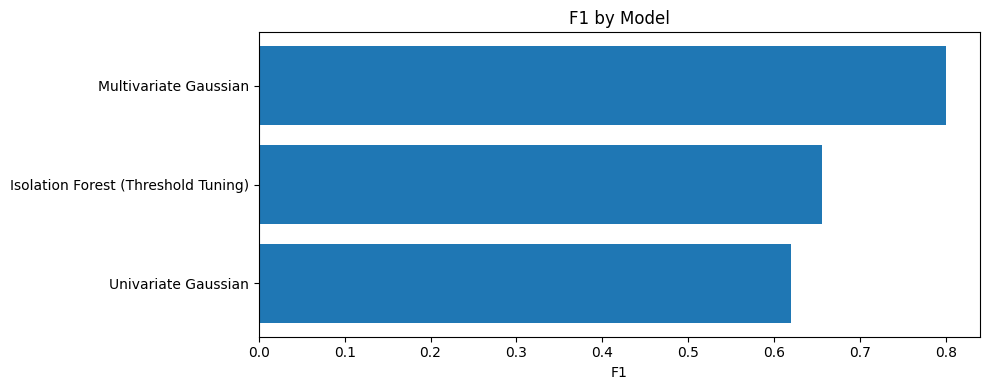

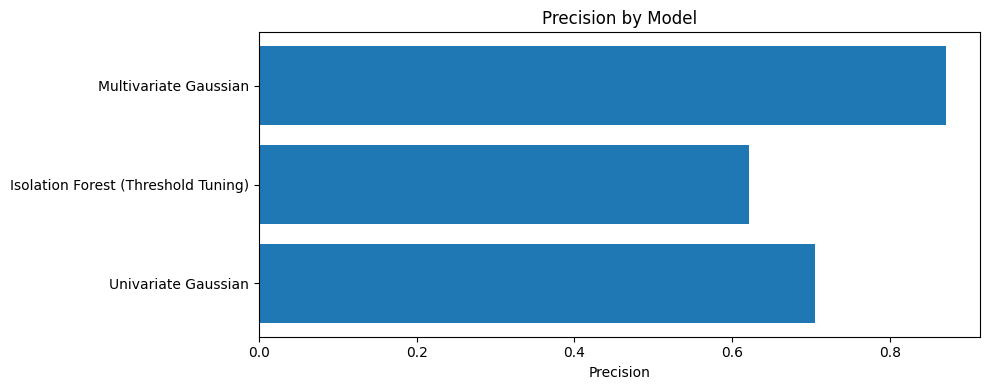

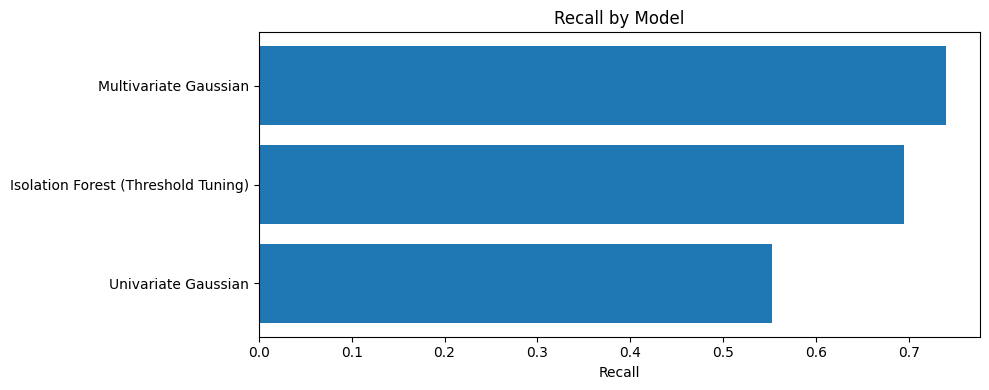

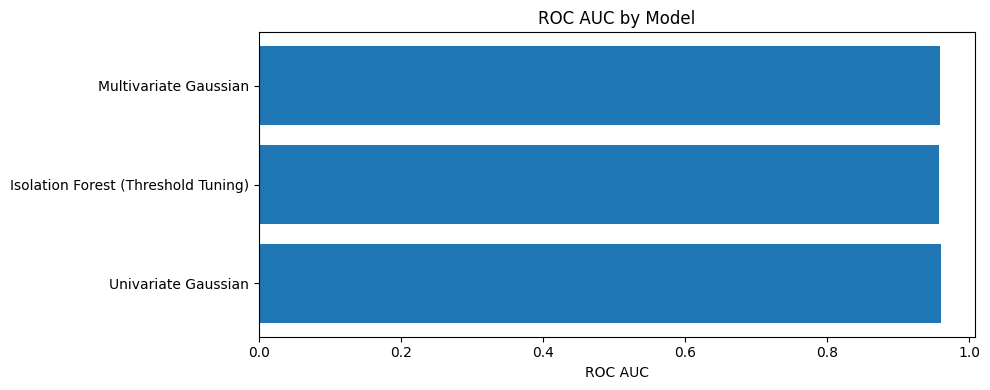

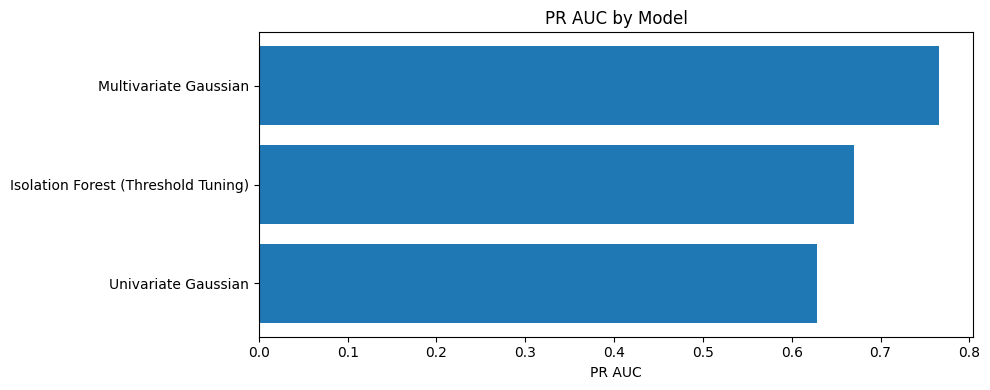

In [71]:
# Visualize metrics
metrics = ['F1', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']

for metric in metrics:
    plt.figure(figsize=(10, 4))
    plt.barh(df_results['Model'], df_results[metric])
    plt.title(f'{metric} by Model')
    plt.xlabel(metric)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Combined ROC and PR Curves for All Models

### Plotting Combined Curves

#### Overlay ROC and PR Curves

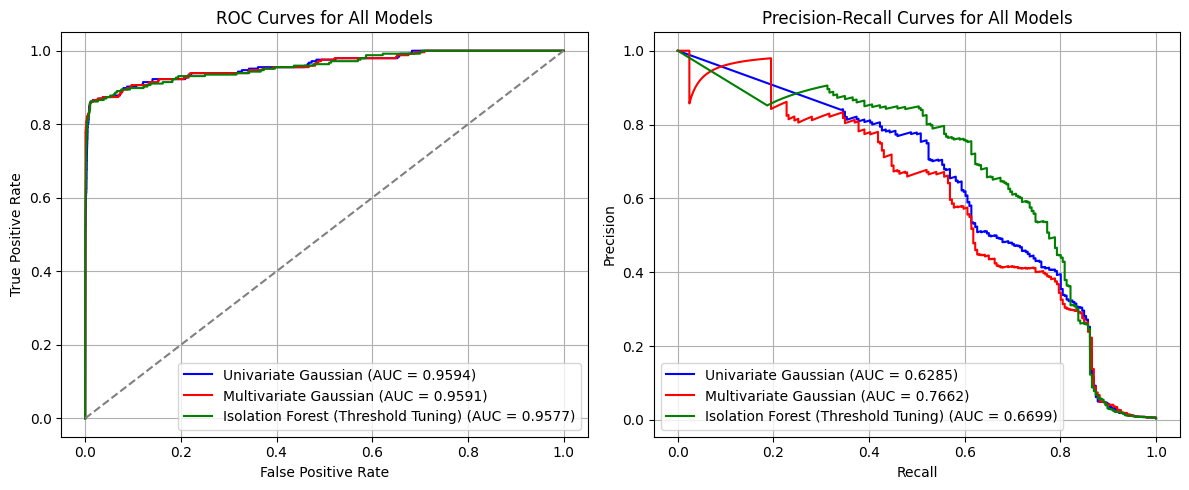

In [72]:
# Define models to compare with exact names
models_to_compare = [
    'Univariate Gaussian',
    'Multivariate Gaussian',
    'Isolation Forest (Threshold Tuning)'
]

# Plot ROC and PR curves
plt.figure(figsize=(12, 5))

# ROC Curve subplot
plt.subplot(1, 2, 1)
colors = ['blue', 'red', 'green']
for idx, model_name in enumerate(models_to_compare):
    # Find the model in curve_metrics
    model_result = next((r for r in curve_metrics if r['Model'] == model_name), None)
    if model_result and all(key in model_result for key in ['fpr', 'tpr', 'ROC AUC']):
        fpr = np.array(model_result['fpr'])  # Convert list back to numpy array
        tpr = np.array(model_result['tpr'])
        roc_auc = model_result['ROC AUC']
        plt.plot(fpr, tpr, color=colors[idx], label=f'{model_name} (AUC = {roc_auc:.4f})')
    else:
        print(f"Error: ROC metrics for {model_name} not found in curve_metrics.")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)

# Precision-Recall Curve subplot
plt.subplot(1, 2, 2)
for idx, model_name in enumerate(models_to_compare):
    # Find the model in curve_metrics
    model_result = next((r for r in curve_metrics if r['Model'] == model_name), None)
    if model_result and all(key in model_result for key in ['prec_curve', 'rec_curve', 'PR AUC']):
        prec = np.array(model_result['prec_curve'])  # Use prec_curve
        rec = np.array(model_result['rec_curve'])    # Use rec_curve
        pr_auc = model_result['PR AUC']
        plt.plot(rec, prec, color=colors[idx], label=f'{model_name} (AUC = {pr_auc:.4f})')
    else:
        print(f"Error: PR metrics for {model_name} not found in curve_metrics.")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.savefig("all_models_roc_pr_curves.png")
plt.show()